#**Personalised ChatBot**

In [1]:
#Libraries Imported
!pip install colorama
!pip install tensorflowjs
import json
import tensorflow as tf
import numpy as np
import sklearn
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
import pickle
from keras.initializers import Constant
import tensorflowjs as tfjs
import colorama 
colorama.init()
from colorama import Back
from colorama import Style
from colorama import Fore
import random
!pip install plot_keras_history
from plot_keras_history import plot_history
import matplotlib.pyplot as plt

In [2]:
with open('intents.json') as file:
    data = json.load(file)

In [3]:
training_sentences = []
training_labels = []
labels = []
responses = []
for intent in data['intents']:
    for pattern in intent['patterns']:
        training_sentences.append(pattern)
        training_labels.append(intent['tag'])
    responses.append(intent['responses'])
    if intent['tag'] not in labels:
        labels.append(intent['tag'])
num_classes = len(labels)

In [4]:
label_encoder = LabelEncoder()
label_encoder.fit(training_labels)
training_labels = label_encoder.transform(training_labels)
vocab_size = 1000
embedding_dim = 16
max_len = 20
oov_token = "<OOV>"
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded_sequences = pad_sequences(sequences, truncating='post', maxlen=max_len)

In [5]:
def readGloveFile(gloveFile):
    with open(gloveFile, 'r') as f:
        wordToGlove = {}  
        wordToIndex = {}  
        indexToWord = {}  
        for line in f:
            record = line.strip().split()
            token = record[0] 
            wordToGlove[token] = np.array(record[1:], dtype=np.float64) 
        tokens = sorted(wordToGlove.keys())
        for idx, tok in enumerate(tokens):
            kerasIdx = idx + 1  
            wordToIndex[tok] = kerasIdx 
            indexToWord[kerasIdx] = tok 
    return wordToIndex, indexToWord, wordToGlove

In [6]:
def createPretrainedEmbeddingLayer(wordToGlove, wordToIndex, isTrainable):
    vocabLen = len(wordToIndex) + 1  
    embDim = next(iter(wordToGlove.values())).shape[0]  
    embeddingMatrix = np.zeros((vocabLen, embDim))  
    for word, index in wordToIndex.items():
        embeddingMatrix[index, :] = wordToGlove[word] 
    embeddingLayer = Embedding(vocabLen, embDim, embeddings_initializer=Constant(embeddingMatrix), trainable=isTrainable, name='GloVe_Embeddings')
    return embeddingLayer

In [7]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip /content/glove.6B.zip

In [8]:
wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.300d.txt')
# vocabLen = len(wordToIndex) + 1 
EMBED_SIZE = next(iter(wordToGlove.values())).shape[0]
print('Size of Embedding: ',EMBED_SIZE)
embeddingLayer=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=False)

Size of Embedding:  300


In [9]:
class GlobalAveragePooling1DMasked(GlobalAveragePooling1D):
    def call(self, x, mask=None):
        if mask != None:
            return K.sum(x, axis=1) / K.sum(mask, axis=1)
        else:
            return super().call(x)


In [10]:
#sequential library is used to add layer one by one
model = Sequential()
#first layer --> pre-trained embedding layer
model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
#second layer --> globalpooling layer
model.add(GlobalAveragePooling1D())
#third layer --> dense layer with 16 hidden layers
model.add(Dense(16, activation='relu'))
#fourth layer --> dense layer with 16 hidden layers
model.add(Dense(16, activation='relu'))
#fifth layer --> output layer
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 16)            16000     
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 15)                255       
Total params: 16,799
Trainable params: 16,799
Non-trainable params: 0
_________________________________________________________________


In [11]:
hidden_layer=16

#sequential library is used to add layer one by one
model1 = Sequential()
#first layer --> pre-trained embedding layer
model1.add(createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=False))
#second layer --> globalpooling layer
model1.add(GlobalAveragePooling1DMasked())
#third layer --> dense layer with 16 hidden layers
model1.add(Dense(hidden_layer, activation="relu", name="hidden_layer"))
#fourth layer --> dense layer with 16 hidden layers
model1.add(Dense(16, activation="relu", name="hidden_layer1"))
#fifth layer --> output layer
model.add(Dense(num_classes, activation='softmax'))

model1.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

model1.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
GloVe_Embeddings (Embedding) (None, None, 300)         120000300 
_________________________________________________________________
global_average_pooling1d_mas (None, 300)               0         
_________________________________________________________________
hidden_layer (Dense)         (None, 16)                4816      
_________________________________________________________________
hidden_layer1 (Dense)        (None, 16)                272       
Total params: 120,005,388
Trainable params: 5,088
Non-trainable params: 120,000,300
_________________________________________________________________


In [12]:
epochs = 8000
history = model.fit(padded_sequences, np.array(training_labels), epochs=epochs)

Streaming output truncated to the last 5000 lines.
Epoch 5501/8000
2/2 [==============================] - 0s 9ms/step - loss: 1.0356
Epoch 5502/8000
2/2 [==============================] - 0s 10ms/step - loss: 1.0356
Epoch 5503/8000
2/2 [==============================] - 0s 8ms/step - loss: 1.0356
Epoch 5504/8000
2/2 [==============================] - 0s 15ms/step - loss: 1.0355
Epoch 5505/8000
2/2 [==============================] - 0s 15ms/step - loss: 1.0355
Epoch 5506/8000
2/2 [==============================] - 0s 9ms/step - loss: 1.0354
Epoch 5507/8000
2/2 [==============================] - 0s 7ms/step - loss: 1.0354
Epoch 5508/8000
2/2 [==============================] - 0s 8ms/step - loss: 1.0353
Epoch 5509/8000
2/2 [==============================] - 0s 6ms/step - loss: 1.0353
Epoch 5510/8000
2/2 [==============================] - 0s 9ms/step - loss: 1.0352
Epoch 5511/8000
2/2 [==============================] - 0s 10ms/step - loss: 1.0352
Epoch 5512/8000
2/2 [======================

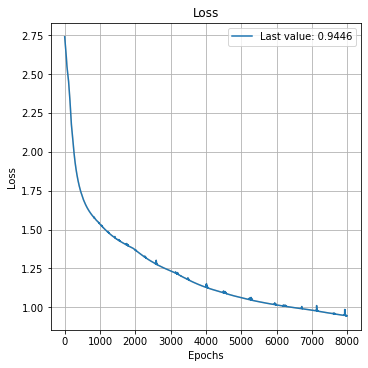

In [13]:
#plotting
plot_history(history.history, path="standard.png")
plt.show()

In [14]:
# to save the trained model
model.save("chatbot_training_model")
# to save the fitted tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
# to save the fitted label encoder
with open('label_encoder.pickle', 'wb') as ecn_file:
    pickle.dump(label_encoder, ecn_file, protocol=pickle.HIGHEST_PROTOCOL)

INFO:tensorflow:Assets written to: chatbot_training_model/assets


In [17]:
def chatbot_activate():
    # load trained model
    model = keras.models.load_model('chatbot_training_model')
    # load tokenizer object
    with open('tokenizer.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)
    # load label encoder object
    with open('label_encoder.pickle', 'rb') as enc:
        lbl_encoder = pickle.load(enc)
    # parameters
    max_len = 20
    
    while True:
        print(Fore.LIGHTBLUE_EX + "User: " + Style.RESET_ALL, end="")
        inp = input()
        if inp.lower() == "quit":
            break
        result = model.predict(keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences([inp]),truncating='post', maxlen=max_len))
        tag = lbl_encoder.inverse_transform([np.argmax(result)])
        for i in data['intents']:
            if i['tag'] == tag:
                print(Fore.GREEN + "ChatBot:" + Style.RESET_ALL , np.random.choice(i['responses']))
        tfjs.converters.save_keras_model(model, 'C:/Users/hp/Documents/Python_Chatbot')
print(Fore.YELLOW + "Start messaging with the bot (type quit to stop)!" + Style.RESET_ALL)
chatbot_activate()

Start messaging with the bot (type quit to stop)!
User: hi
ChatBot: Yes Sure, How can I support you
User: wh are you
ChatBot: You're most welcome!
User: who are you
ChatBot: I'm Mac, an Artificial Intelligent bot
User: how are you
ChatBot: You're most welcome!
User: zara website
ChatBot: https://www.zara.com/uk/
User: united colours of Benetton website
ChatBot: https://gb.benetton.com
User: vaccine registration 
ChatBot: https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwi1wKiqxY_xAhWJnxQKHWq4DLoQFjAAegQIBhAD&url=https%3A%2F%2Fwww.nhs.uk%2Fconditions%2Fcoronavirus-covid-19%2Fcoronavirus-vaccination%2Fbook-coronavirus-vaccination%2F&usg=AOvVaw0iU_xs7XjaIWwVoUtvAq1W , Book Vaccine now on header section for registration. You just have to click on it and fill the registration form. 
User: thank you
ChatBot: Two vaccines that have been granted emergency use authorization by the government of united kingdom  are Pfizer® (produced by American Multinational company Pfize